In [1]:
# Import required libraries for numerical operations, data manipulation, and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import library for regular expressions to preprocess text data
import re 
import unicodedata

# Import preprocessing tools for encoding labels and transforming text data
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Import functions for splitting data and machine learning models
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.multiclass import OneVsRestClassifier

# Import metrics for evaluating model performance
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#import tensorflow to build Deep Learning model using LSTM Model
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Embedding, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK tools
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\ahmed
[nltk_data]     yasser\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ahmed
[nltk_data]     yasser\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# Define the text cleaning function
def cleanResume(txt):
    """
    Clean resume text by normalizing non-ASCII characters, removing URLs, hashtags, mentions,
    punctuation, stopwords, category names, and applying lemmatization.
    
    Parameters:
        txt (str): Raw resume text.
    Returns:
        str: Cleaned resume text.
    """
    cleanText = unicodedata.normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')
    cleanText = re.sub(r'http[s]?://\S+', ' ', cleanText)
    cleanText = re.sub(r'#[^\s]+', ' ', cleanText)
    cleanText = re.sub(r'@[^\s]+', ' ', cleanText)
    cleanText = re.sub(r'[!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~]', ' ', cleanText)
    cleanText = cleanText.lower()
    categories = [
        'java developer', 'testing', 'devops engineer', 'python developer', 'web designing',
        'hr', 'hadoop', 'blockchain', 'etl developer', 'operations manager', 'data science',
        'sales', 'mechanical engineer', 'arts', 'database', 'electrical engineering',
        'health and fitness', 'pmo', 'business analyst', 'dotnet developer', 'automation testing',
        'network security engineer', 'sap developer', 'civil engineer', 'advocate',
        'java', 'devops', 'python', 'etl', 'data scientist', 'business analysis', 'automation'
    ]
    for category in categories:
        cleanText = re.sub(rf'\b{category}\b', ' ', cleanText, flags=re.IGNORECASE)
    words = cleanText.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    cleanText = ' '.join(words)
    cleanText = re.sub(r'\s+', ' ', cleanText).strip()
    return cleanText

In [4]:
# Load the resume dataset 
df = pd.read_csv("UpdatedResumeDataSet.csv")

# Display the first five rows
df.head()

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."


In [5]:
# Display the last five rows 
df.tail()

,Category,Resume
957,Testing,Computer Skills: â¢ Proficient in MS office (...
958,Testing,â Willingness to accept the challenges. â ...
959,Testing,"PERSONAL SKILLS â¢ Quick learner, â¢ Eagerne..."
960,Testing,COMPUTER SKILLS & SOFTWARE KNOWLEDGE MS-Power ...
961,Testing,Skill Set OS Windows XP/7/8/8.1/10 Database MY...


In [6]:
# Check dataset size and categories
print(f"Dataset shape: {df.shape}")
print(f"Number of unique categories: {len(df['Category'].unique())}")

Dataset shape: (962, 2)
Number of unique categories: 25


In [7]:
# Get the unique job categories in the dataset
df['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [8]:
# Display the frequency distribution of job categories
df['Category'].value_counts()

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: count, dtype: int64

C:\Users\ahmed yasser\AppData\Local\Temp\ipykernel_27032\793498748.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index, palette='Set2')


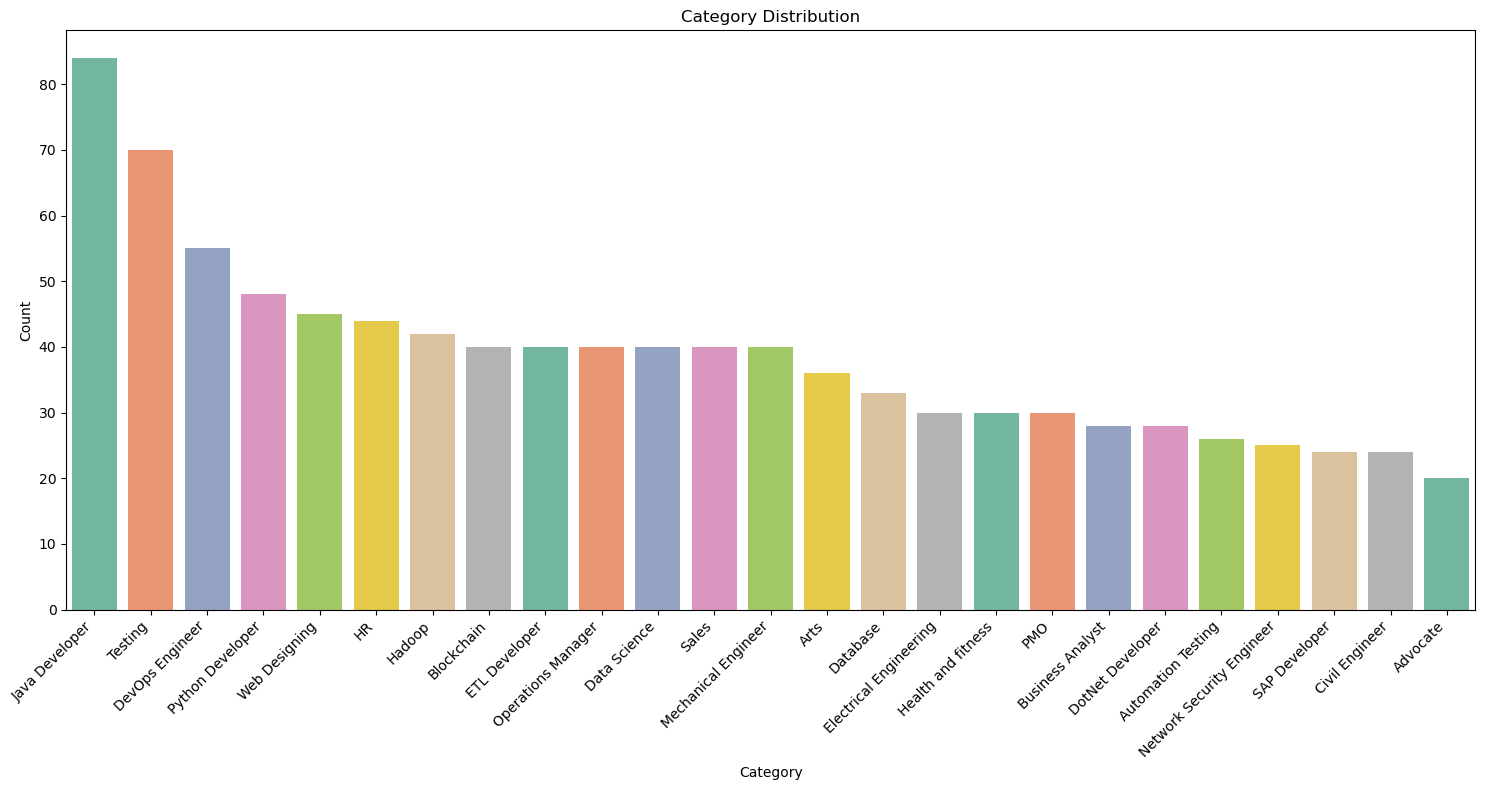

In [9]:
#  Plot category distribution
plt.figure(figsize=(15, 8))
sns.countplot(data=df, x='Category', order=df['Category'].value_counts().index, palette='Set2')
plt.title('Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

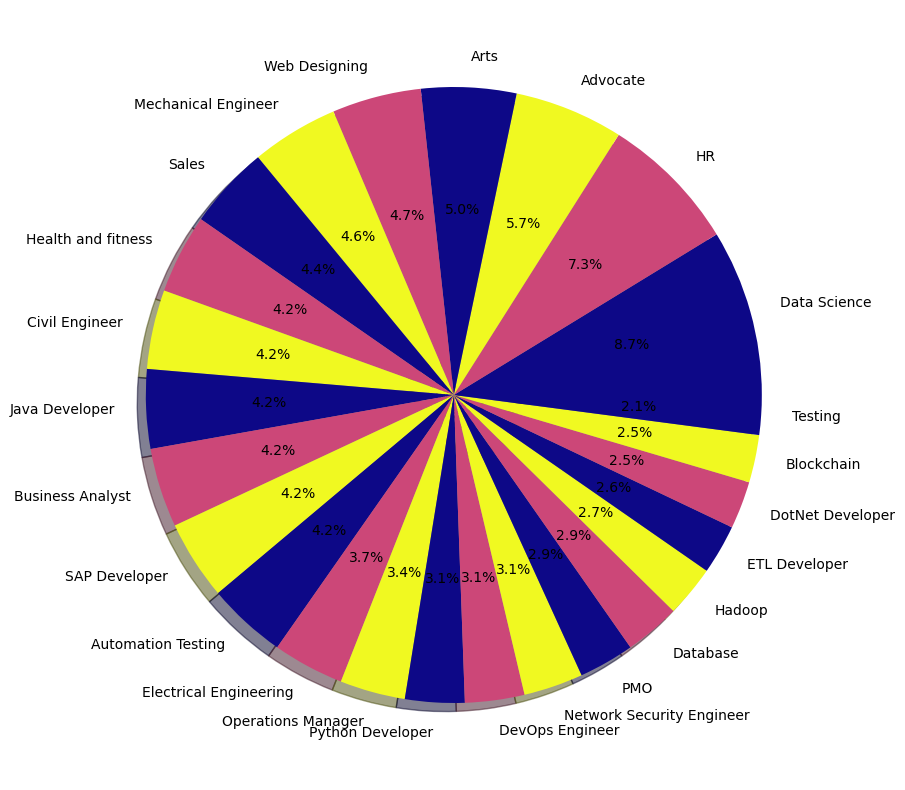

In [10]:
# Calculate the frequency of each category and get unique labels
counts = df['Category'].value_counts()
labels = df['Category'].unique()

# Set up a pie chart to show the proportion of each category
plt.figure(figsize=(15,10)) 
plt.pie(counts, labels=labels, autopct='%1.1f%%', shadow=True, colors=plt.cm.plasma(np.linspace(0,1,3)))
plt.show() 

In [11]:
# Check for potential data leakage (category names in resumes)
category_names = df['Category'].str.lower().unique()
for category in category_names:
    count = df['Resume'].str.lower().str.contains(category).sum()
    if count > 0:
        print(f"Warning: Category '{category}' appears in {count} resumes, possible data leakage!")

In [12]:
# Apply text cleaning
df['Cleaned_Resume'] = df['Resume'].apply(cleanResume)

In [13]:
# Verify cleaning
for category in category_names:
    count = df['Cleaned_Resume'].str.lower().str.contains(category).sum()
    if count > 0:
        print(f"Warning: Category '{category}' still appears in {count} cleaned resumes!")

In [14]:
# Encode the Category column
le = LabelEncoder()
df['Category_encoded'] = le.fit_transform(df['Category'])

In [15]:
# Vectorize for traditional models
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english', ngram_range=(1, 2))
X = vectorizer.fit_transform(df['Cleaned_Resume'])
y = df['Category_encoded']

In [16]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# Initialize traditional models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),
    'Support Vector Machine': SVC(kernel='linear', C=0.1, probability=True),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42),
    'Logistic Regression': LogisticRegression(C=0.1, max_iter=1000, random_state=42),
    'Naive Bayes': OneVsRestClassifier(GaussianNB())
}

In [18]:
# Dictionary to store accuracy scores
model_scores = {}

In [19]:
# Train and evaluate traditional models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    if model_name == 'Naive Bayes':
        X_dense = X.toarray()
        cv_scores = cross_val_score(model, X_dense, y, cv=5, scoring='accuracy')
    else:
        cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"{model_name} Cross-Validation Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")
    
    if model_name == 'Naive Bayes':
        X_train_dense = X_train.toarray()
        X_test_dense = X_test.toarray()
        model.fit(X_train_dense, y_train)
        y_pred = model.predict(X_test_dense)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    model_scores[model_name] = accuracy
    print(f"\n{model_name} Test Set Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_, zero_division=0))
    print("-" * 50)

Training K-Nearest Neighbors...
K-Nearest Neighbors Cross-Validation Accuracy: 0.9709 (±0.0121)

K-Nearest Neighbors Test Set Results:
Accuracy: 0.9430

Classification Report:
                           precision    recall  f1-score   support

                 Advocate       0.00      0.00      0.00         3
                     Arts       0.75      1.00      0.86         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      1.00      1.00         9
             Data Science       0.75      0.60      0.67         5
                 Database       1.00      0.88      0.93         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engin

In [20]:
# Prepare data for LSTM
tokenizer = Tokenizer(num_words=5000)  # Increased vocab size
tokenizer.fit_on_texts(df['Cleaned_Resume'])
X_seq = tokenizer.texts_to_sequences(df['Cleaned_Resume'])
X_pad = pad_sequences(X_seq, maxlen=300, padding='post')  # Increased maxlen

In [21]:
# Split data for LSTM
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(X_pad, y, test_size=0.2, random_state=42)

In [22]:
# Build enhanced LSTM model
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=300),
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(le.classes_), activation='softmax')
])

In [23]:
# Compile LSTM model
lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [24]:
# Train LSTM with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
print("Training LSTM...")
history = lstm_model.fit(
    X_train_dl, y_train_dl,
    epochs=30,
    batch_size=16,  # Smaller batch size for better learning
    validation_split=0.2,
    callbacks=[early_stopping],
    verbose=1
)

Training LSTM...
Epoch 1/30
39/39 [==============================] - 12s 107ms/step - loss: 3.1690 - accuracy: 0.0797 - val_loss: 3.1082 - val_accuracy: 0.1234
Epoch 2/30
39/39 [==============================] - 3s 67ms/step - loss: 2.8391 - accuracy: 0.1951 - val_loss: 2.6306 - val_accuracy: 0.2532
Epoch 3/30
39/39 [==============================] - 3s 67ms/step - loss: 2.3183 - accuracy: 0.2927 - val_loss: 2.2617 - val_accuracy: 0.3182
Epoch 4/30
39/39 [==============================] - 3s 68ms/step - loss: 1.9707 - accuracy: 0.4065 - val_loss: 2.0102 - val_accuracy: 0.3442
Epoch 5/30
39/39 [==============================] - 3s 68ms/step - loss: 1.6862 - accuracy: 0.4846 - val_loss: 1.7563 - val_accuracy: 0.4740
Epoch 6/30
39/39 [==============================] - 3s 68ms/step - loss: 1.3687 - accuracy: 0.5675 - val_loss: 1.3525 - val_accuracy: 0.6234
Epoch 7/30
39/39 [==============================] - 3s 66ms/step - loss: 1.1698 - accuracy: 0.6325 - val_loss: 1.1654 - val_accuracy: 0

In [25]:
# Evaluate LSTM on test set
y_pred_dl = lstm_model.predict(X_test_dl)
y_pred_dl = np.argmax(y_pred_dl, axis=1)
lstm_accuracy = accuracy_score(y_test_dl, y_pred_dl)
model_scores['LSTM'] = lstm_accuracy


print("\nLSTM Test Set Results:")
print(f"Accuracy: {lstm_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_dl, y_pred_dl, target_names=le.classes_, zero_division=0))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test_dl, y_pred_dl))
print("-" * 50)

7/7 [==============================] - 2s 44ms/step

LSTM Test Set Results:
Accuracy: 0.9637

Classification Report:
                           precision    recall  f1-score   support

                 Advocate       0.00      0.00      0.00         3
                     Arts       1.00      1.00      1.00         6
       Automation Testing       1.00      1.00      1.00         5
               Blockchain       1.00      1.00      1.00         7
         Business Analyst       1.00      1.00      1.00         4
           Civil Engineer       1.00      0.67      0.80         9
             Data Science       1.00      1.00      1.00         5
                 Database       1.00      1.00      1.00         8
          DevOps Engineer       1.00      0.93      0.96        14
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         7
   Electrical Engineering       1.00      1.00      1.00         6
           

In [26]:
# Model comparison
print("\nModel Comparison (Test Set Accuracy):")
for model_name, accuracy in model_scores.items():
    print(f"{model_name}: {accuracy:.4f}")
best_model_name = max(model_scores, key=model_scores.get)
best_accuracy = model_scores[best_model_name]
print(f"\nBest Model: {best_model_name} with Test Accuracy: {best_accuracy:.4f}")


Model Comparison (Test Set Accuracy):
K-Nearest Neighbors: 0.9430
Support Vector Machine: 0.6995
Random Forest: 0.9637
Logistic Regression: 0.5492
Naive Bayes: 0.9637
LSTM: 0.9637

Best Model: Random Forest with Test Accuracy: 0.9637


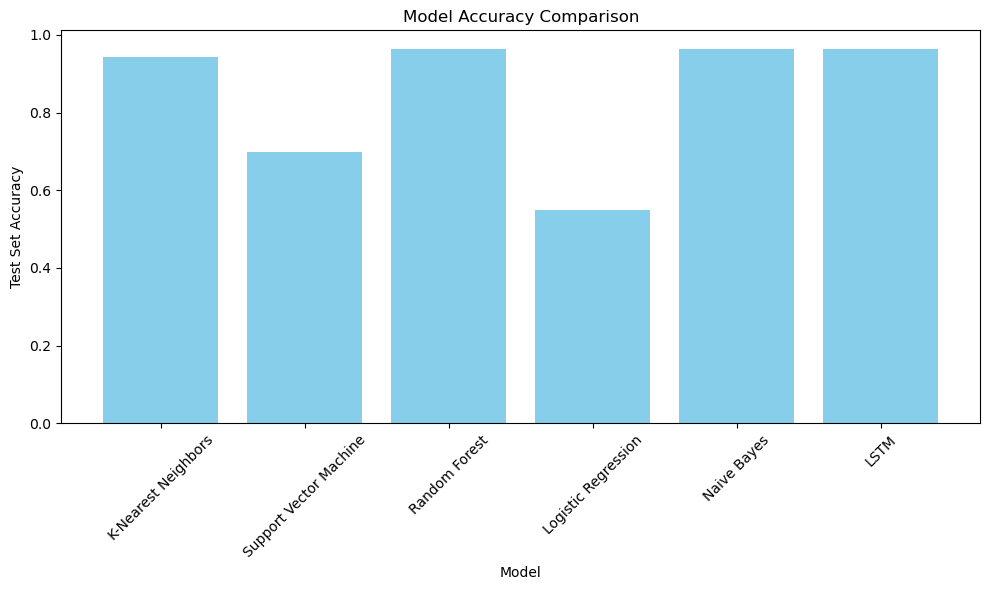

In [27]:
# Bar plot for model accuracies
plt.figure(figsize=(10, 6))
plt.bar(model_scores.keys(), model_scores.values(), color='skyblue')
plt.title('Model Accuracy Comparison')
plt.xlabel('Model')
plt.ylabel('Test Set Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

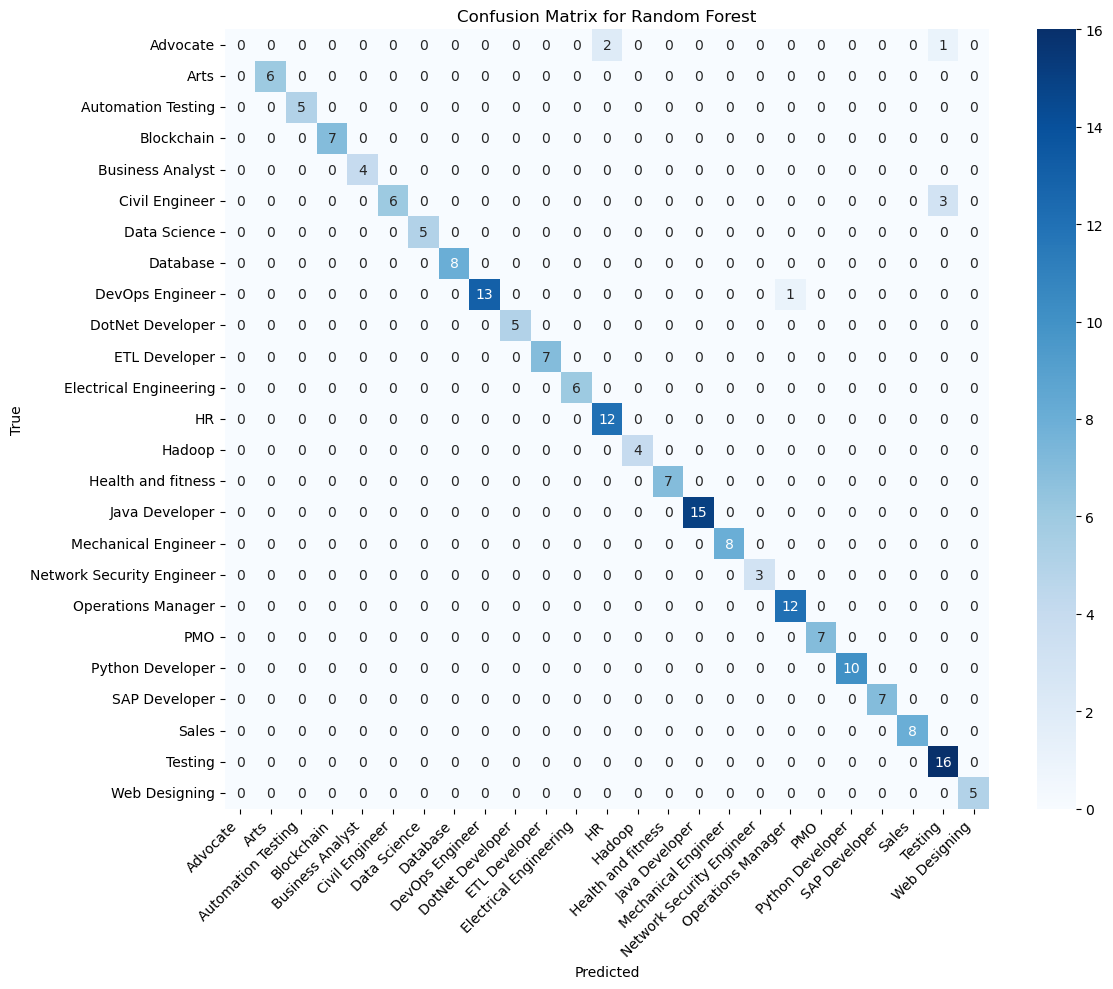

In [28]:
# 2. Confusion matrix heatmap for the best model
best_model_name = max(model_scores, key=model_scores.get)
if best_model_name == 'LSTM':
    y_pred_best = y_pred_dl
else:
    if best_model_name == 'Naive Bayes':
        y_pred_best = models[best_model_name].predict(X_test.toarray())
    else:
        y_pred_best = models[best_model_name].predict(X_test)
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix(y_test, y_pred_best), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

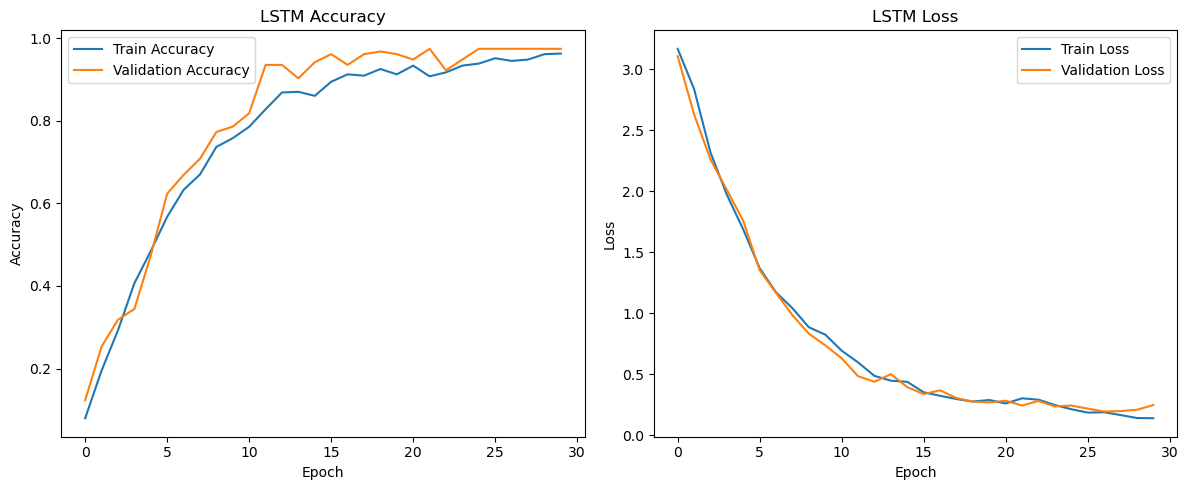

In [29]:
# 3. Learning curves for LSTM
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [30]:
# Save the best model
if best_model_name == 'LSTM':
    lstm_model.save('best_resume_classifier.h5')
    joblib.dump(tokenizer, 'tokenizer.pkl')
else:
    if best_model_name == 'Naive Bayes':
        X_dense = X.toarray()
        models[best_model_name].fit(X_dense, y)
    else:
        models[best_model_name].fit(X, y)
    joblib.dump(models[best_model_name], 'best_resume_classifier.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
joblib.dump(le, 'label_encoder.pkl')
print("\nBest model, vectorizer/tokenizer, and label encoder saved successfully!")


Best model, vectorizer/tokenizer, and label encoder saved successfully!


In [31]:
import joblib
model = joblib.load('best_resume_classifier.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')
le = joblib.load('label_encoder.pkl')
print("Model, vectorizer, and label encoder loaded successfully!")

Model, vectorizer, and label encoder loaded successfully!
